#### **Libraries**

In [71]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, spectrogram,hilbert
from bokeh.plotting import figure, show
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook
from bokeh.palettes import Viridis256
from bokeh.models import Title
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from functions import *

output_notebook()

Loading BokehJS ...

#### **Data Visualization**

In [72]:
# Define the path to the folder containing particle data
path_folder = "./Particle_Segmentation/Particles_Data/"

# Names of folders containing raw particle data
Name_Folder = ['Raw_2um','Raw_4um','Raw_10um'] 
# Corresponding names of folders with the processed data
Final_Folder = ['DB_2um','DB_4um','DB_10um'] 

# Define experiment parameters
# Acquisition frequency in Hertz (samples per second)
Adq_Freq = 2000000  
# Time duration of captured data in milliseconds
Time_Captured_ms = 16384  
# Parameters of the SMI sensor used for particle detection
Particle_Params = {
    "laser_lambda": 1.55e-6,  # Wavelength of the laser in meters
    "angle": 22,              # Angle of incidence in degrees
    "beam_spot_size": 90e-6,  # Size of the laser beam spot in meters
}


#File Name
Sample_to_plot=path_folder+Name_Folder[1]+'/HFocusing_5_10_4um_0_859.npy'
particle_data = np.load(Sample_to_plot)
# Convert time captured to seconds
Time_Captured_s = Time_Captured_ms / 1000  # milliseconds to seconds
# Generate time axis based on the acquisition frequency
time_axis = np.linspace(0, Time_Captured_s, len(particle_data))

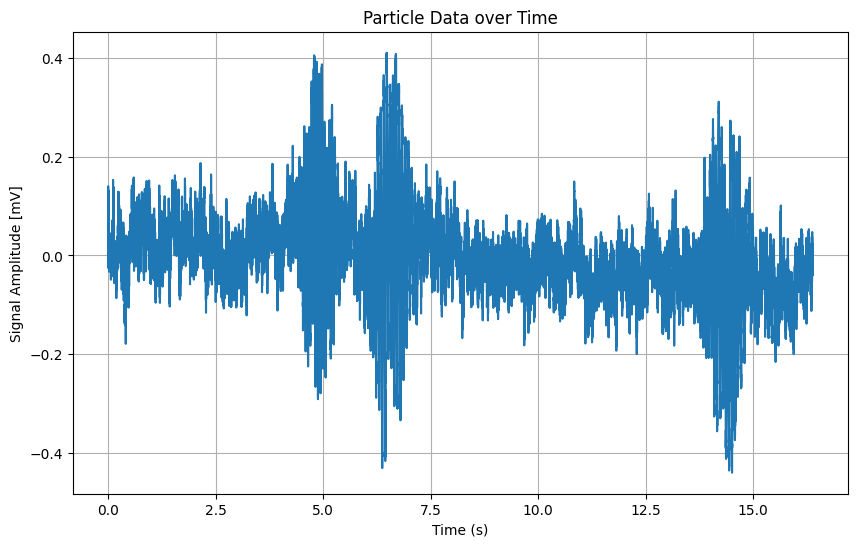

In [73]:
# Plot the RAW particle data
plt.figure(figsize=(10, 6))
plt.plot(time_axis, particle_data)
plt.title('Particle Data over Time')
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplitude [mV]')
plt.grid(True)
plt.show()

In [79]:
def plot_spectrogram(file, adq_freq, time_captured_ms, particle_params):
    # Load particle data from the file
    data_Y = np.load(file)
    data_Y = pd.Series(data_Y)

    # Calculate time axis
    data_X_max = time_captured_ms * 1000 / adq_freq
    data_X = np.linspace(0, data_X_max, time_captured_ms)

    # Remove DC offset
    data_Y_NoOffset = data_Y - data_Y.mean()

    # Apply bandpass filter to the signal
    y_Filtrada = butter_bandpass_filter(data_Y_NoOffset, 7000, 100000, 4, adq_freq)

    # Perform FFT
    ampFFT1, freqfft1, _ = FFT_calc(y_Filtrada, adq_freq)

    # Apply Gaussian smoothing and find peaks
    std_dev = 20
    cut_index = int(len(ampFFT1) / 10)
    new_FFT = ampFFT1[0:cut_index]
    filtered_fft = gaussian_filter1d(new_FFT, sigma=std_dev)

    # Find peaks in the FFT
    mean_amplitude = max(filtered_fft) / 2
    peaks, properties = find_peaks(filtered_fft, height=mean_amplitude)
    peak_amplitudes = properties["peak_heights"]

    # Sort peaks by amplitude and apply a minimum distance criterion
    sorted_indices = np.argsort(peak_amplitudes)[::-1]
    sorted_peaks = peaks[sorted_indices]
    min_distance = 12000
    valid_peaks = []

    peak_i=0
    # Ensure valid peaks are spaced by at least 12 kHz
    for peak in sorted_peaks:
        if all(abs(freqfft1[peak] - freqfft1[vp]) >= min_distance for vp in valid_peaks):
            valid_peaks.append(peak)

            # Spectrogram centered around the valid peaks (assuming find_spectogram is defined)
            t, f_new, Sxx_new = find_spectogram(y_Filtrada, adq_freq, ampFFT1, freqfft1, particle_params)

            # Calculate the general mean for plotting
            general_mean = np.mean(Sxx_new, axis=0)

            # Adjust time axis for the spectrogram plot
            t = np.linspace(0, max(data_X), len(general_mean))

            # Setup Bokeh plot for the spectrogram
            title=(f'Spectrogram around Peak {peak_i+1} - Frequency: {peak:.2f} Hz')
            spectrogram_fig = figure(title=title, x_axis_label="Time (ms)", y_axis_label="Frequency (Hz)",
                                    width=800)

            # Setup the color mapper based on the Viridis palette
            color_mapper = LinearColorMapper(palette=Viridis256, low=np.min(Sxx_new), high=np.max(Sxx_new))

            # Plot the spectrogram image
            spectrogram_fig.image(image=[Sxx_new], x=0, y=0, dw=t[-1], dh=f_new[-1], color_mapper=color_mapper)

            # Show the Bokeh plot
            show(spectrogram_fig)


In [80]:
plot_spectrogram(Sample_to_plot, Adq_Freq, Time_Captured_ms, Particle_Params)

In [81]:
def plot_gaussian_fit(file, adq_freq, time_captured_ms, particle_params):
    # Load particle data from the file
    data_Y = np.load(file)
    data_Y = pd.Series(data_Y)

    # Calculate time axis
    data_X_max = time_captured_ms * 1000 / adq_freq
    data_X = np.linspace(0, data_X_max, time_captured_ms)

    # Remove DC offset
    data_Y_NoOffset = data_Y - data_Y.mean()

    # Apply bandpass filter to the signal
    y_Filtrada = butter_bandpass_filter(data_Y_NoOffset, 7000, 100000, 4, adq_freq)

    # Perform FFT and generate the spectrogram
    ampFFT1, freqfft1, _ = FFT_calc(y_Filtrada, adq_freq)
    t, f_new, Sxx_new = find_spectogram(y_Filtrada, adq_freq, ampFFT1, freqfft1, particle_params)

    # Mean of the spectrogram for classification
    general_mean = np.mean(Sxx_new, axis=0)
    t = np.linspace(0, max(data_X), len(general_mean))

    # Classify valid zones and detect anomalies
    valid_zones, anomalies = classify_zones(general_mean, [5, 10])

    # Plot the detected particles and Gaussian fits
    if valid_zones:
        plt.subplot(1, 1, 1)
        counter_counter = 0  # Count valid Gaussian fits
        
        for i, vv in enumerate(valid_zones):
            vv = list(vv)
            if vv != (0, 0):
                # Adjust boundaries
                if vv[0] < 3:
                    vv[0] = 3
                if vv[1] + 3 >= len(t):
                    vv[1] = -4
                
                # Extract valid data for fitting
                highlight_mask = (data_X >= t[vv[0] - 3]) & (data_X <= t[vv[1] + 3])
                highlight_mask = adjust_mask_and_extract(data_X, highlight_mask, 2500)

                valid_P_x = data_X[highlight_mask]
                valid_P_y = y_Filtrada[highlight_mask]

                # Normalize and process the data for Gaussian fitting
                x_data = np.linspace(0, len(valid_P_x), len(valid_P_x))
                valid_P_y2 = (valid_P_y - np.min(valid_P_y)) / (np.max(valid_P_y) - np.min(valid_P_y))
                valid_P_y2 = 2 * valid_P_y2 - 1  # Rescale between -1 and 1
                valid_P_y2 = np.abs(hilbert(valid_P_y))  # Hilbert transform to get the envelope

                # Initial parameters for curve fitting
                initial_params = [np.max(valid_P_y2) * 10, np.argmax(valid_P_y2), 1.0]

                try:
                    # Perform Gaussian fit
                    optimized_params, _ = curve_fit(gaussian, x_data, valid_P_y2)
                    amplitude, mean, stddev = optimized_params
                    y_curve = gaussian(x_data, amplitude, mean, stddev)

                    # Check if the fit is valid
                    if (max(y_curve) > y_curve[0] + 0.05) and (max(y_curve) > y_curve[-1] + 0.05):
                        counter_counter += 1
                        plt.plot(valid_P_x, valid_P_y, label=f"Particle {counter_counter}", color="green")
                        plt.plot(valid_P_x, y_curve, label=f"Gaussian Fit {counter_counter}", color="red", linestyle='--')
                    else:
                        plt.plot(valid_P_x, valid_P_y, label="No Fit", color="yellow")

                except Exception as e:
                    print(f"Fit failed for particle {i + 1}: {str(e)}")
                    plt.plot(valid_P_x, valid_P_y, label="No Fit", color="yellow")

        plt.legend()
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.title("Detected Particles and Gaussian Fits")

    plt.tight_layout()
    plt.show()



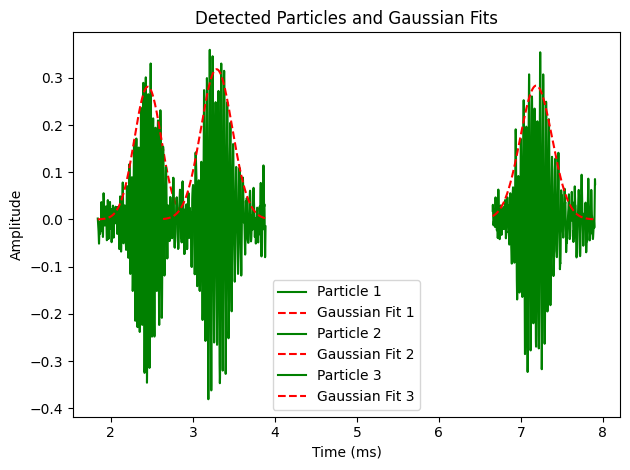

In [82]:

plot_gaussian_fit(Sample_to_plot, Adq_Freq, Time_Captured_ms, Particle_Params)